# Diffusion-Reaction SEIR-SEI Dengue Spread Model 

M.K. Enduri and S. Jolad, 2018, “Dynamics of dengue disease with human and vector mobility,” Spatial and Spatio-temporal Epidemiology, 25, pp. 57–66, https://doi.org/10.1016/j.sste.2018.03.001

Human

$ \frac{\delta s_h}{\delta t} = D_h \nabla^2 s_h + \mu_h n_h - \beta_{vh} s_h i_v - \mu_h s_h$

$ \frac{\delta e_h}{\delta t} = D_h \nabla^2 e_h + \beta_{vh} s_h i_v - \alpha_h e_h - \mu_h e_h$

$ \frac{\delta i_h}{\delta t} = D_h \nabla^2 i_h + \alpha_h e_h - r_h i_h - \mu_h i_h$

$ \frac{\delta r_h}{\delta t} = D_h \nabla^2 r_h + r i_h - \mu_h i_h$

Vector 

$ \frac{\delta s_v}{\delta t} = D_v \nabla^2 s_v + \mu_v n_v - \beta_{hv} s_v i_h - \mu_v s_v$

$ \frac{\delta e_v}{\delta t} = D_v \nabla^2 e_v + \beta_{hv} s_v i_h - \alpha_v e_v - \mu_v e_v$

$ \frac{\delta i_v}{\delta t} = D_v \nabla^2 i_v + \alpha_v e_v - r_v i_v - \mu_v i_v$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Solving by Finite Difference Method

In [ ]:
def get_f(D_v, D_h, mu_h, mu_v, beta_hv, beta_vh, r, alpha_h, alpha_v):
    def diffusion_term(soln, i, j, dx, dy, state):
        # Finite Difference Approximation of the 2D Laplacian Operator
        x_term = (soln[i+1][j][state] - 2 * soln[i][j][state] + soln[i-1][j][state]) / (dx ** 2)
        y_term = (soln[i][j+1][state] - 2 * soln[i][j][state] + soln[i][j-1][state]) / (dy ** 2)
        return x_term + y_term
    
    def f(soln, i, j, dx, dy):
        # Human SEIR
        s_h = soln[i][j][0]
        e_h = soln[i][j][1]
        i_h = soln[i][j][2]
        r_h = soln[i][j][3]
        n_h = s_h + e_h + i_h + r_h

        # Vector SEI
        s_v = soln[i][j][4]
        e_v = soln[i][j][5]
        i_v = soln[i][j][6]
        n_v = s_v + e_v + i_v

       
        return np.array([
            # Humans
            D_h * diffusion_term(soln, i, j, dx, dy, 0) + mu_h * n_h - beta_vh * s_h * i_v - mu_h * s_h,
            D_h * diffusion_term(soln, i, j, dx, dy, 1) + beta_vh * s_h * i_v - alpha_h * e_h - mu_h * e_h,
            D_h * diffusion_term(soln, i, j, dx, dy, 2) + alpha_h * e_h - r * i_h - mu_h * i_h,
            D_h * diffusion_term(soln, i, j, dx, dy, 3) + r * i_h - mu_h * r_h,
            # Vectors 
            D_v * diffusion_term(soln, i, j, dx, dy, 4) + mu_v * n_v - beta_hv * s_v * i_h - mu_v * s_v, 
            D_v * diffusion_term(soln, i, j, dx, dy, 5) + beta_hv * s_v * i_h - alpha_v * e_v - mu_v * e_v, 
            D_v * diffusion_term(soln, i, j, dx, dy, 6) + alpha_v * e_v - r * i_v - mu_v * i_v
        ])
        
    return f

def get_compartment_values(matrix, compartment_id, row, col):
    # matrix - storage 
    # compartment_id - s_h=0, e_h=1, i_h=2, r_h=3, s_v=4, e_v=5, i_v=6
    return [[matrix[i][j][compartment_id] for j in range(col)] for i in range(row)]

def get_compartment_total(matrix, compartment_id, row, col):
    total = 0
    for i in range(row):
        for j in range(col):
            total += matrix[i][j][compartment_id]
    return total

# Parameter Values
D_v = 0.2           # Diffusion Coefficient (vector)
D_h = 200 * D_v     # Diffusion Coefficient (humans)
mu_h = 0.0000391    # Death rate of humans
mu_v = 0.07142      # Death rate of vectors
beta_hv = 0.00392   # Infection rate from human to vector
beta_vh = 0.0245    # Infection rate from vector to human
r = 0.07142         # Recovery rate of human population
alpha_h = 0.2       # Rate at which exposed human change to be infected human
alpha_v = 0.1       # Rate at which exposed vector change to be infected vector

# Function f 
f = get_f(D_v, D_h, mu_h, mu_v, beta_hv, beta_vh, r, alpha_h, alpha_v)

# Time and Space 
row = 500           # rows
col = 500           # columns
dt = 0.5              # time step size
dx = 1              # x step size
dy = 1              # y step size

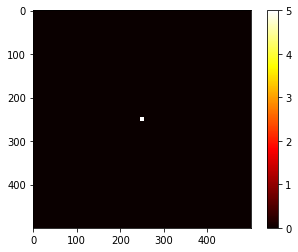

In [ ]:
# Initial Value: Human and Vectors
human_per_cell = 10
vector_per_cell = 10

# Instantiating the initial value storage
initial = [[np.array([human_per_cell, 0, 0, 0, vector_per_cell, 0, 0]) for j in range(col)] for i in range(row)]

# Populating the middle cells (middle -+ 5) with infectious vectors
infected_vector_per_cell = 5
for i in range(row // 2 - 5, row // 2 + 5):
    for j in range(row // 2 - 5, row//2 + 5):
        initial[i][j][6] = infected_vector_per_cell

# Plotting the initial value matrix
im = plt.imshow(get_compartment_values(initial, 6, row, col), cmap='hot', interpolation='nearest')
plt.colorbar(im)

In [ ]:
import copy 

# Solution Storage
soln = [initial]

# SEIR-SEI Storage
seir = []

# Number of model steps 
steps = 50

print("Running...")
for t in range(1, steps):
    print(t)
    # Last Solution 
    last_soln = soln[t-1]
    
    # Latest Solution
    latest_soln = [[np.zeros(7) for j in range(col)] for i in range(row)]

    for i in range(1, row-1):
        for j in range(1, col-1):
            # Euler Step 
            latest_soln[i][j] = last_soln[i][j] + (f(last_soln, i, j, dx, dy) * dt)

    # Adding boundary values
    for i in [0, row - 1]:
        for j in [0, col - 1]:
            latest_soln[i][j] = copy.deepcopy(last_soln[i][j])

    # Appending latest solution to the storage
    soln.append(copy.deepcopy(latest_soln))
print("Done")

Running...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars


17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invali

18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Done


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:455: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:460: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact


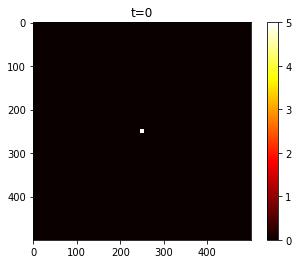

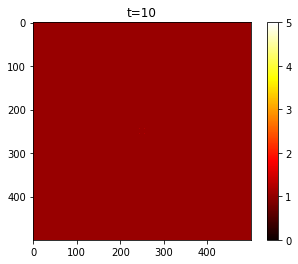

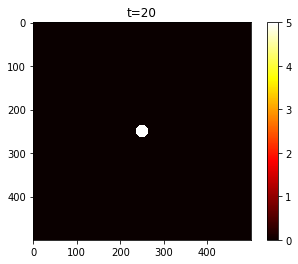

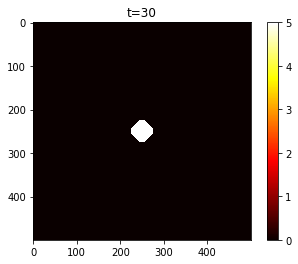

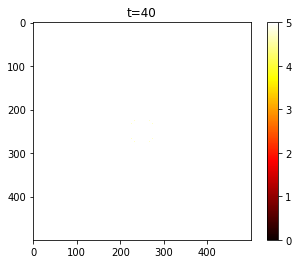

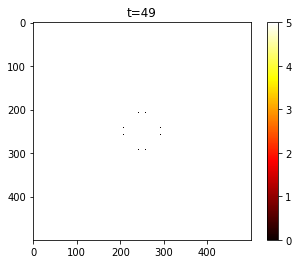

In [ ]:
for time in [0, 10, 20, 30, 40, 49]:
    plt.figure()
    plt.title("t=%i" %(time))
    plt.imshow(get_compartment_values(soln[time], 6, row, col), cmap='hot', interpolation='nearest')
    plt.colorbar(im)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars


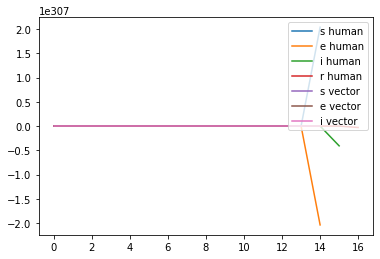

In [ ]:
labels = {
    0: "s human",
    1: "e human",
    2: "i human", 
    3: "r human", 
    4: "s vector", 
    5: "e vector", 
    6: "i vector"
}

for state in range(7):
    time = []
    compartment = []
    for t in range(steps):
        time.append(t)
        compartment.append(get_compartment_total(soln[t], state, row, col))
    plt.plot(time, compartment, label=labels[state])
plt.legend()

In [ ]:
import time 

for t in [0, 5, 9]:
    plt.figure()
    plt.imshow(get_compartment_values(soln[t], 2, row, col), cmap='hot', interpolation='nearest')
    plt.colorbar(im)